In [1]:
!pip install shap
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.4 MB/s eta 0:00:00


In [2]:
!gdown 16r8U9ouAazF5FbNOgan__jsFwMq-tKlb # train

Downloading...
From: https://drive.google.com/uc?id=16r8U9ouAazF5FbNOgan__jsFwMq-tKlb
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 58.4MB/s]


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
def make_data():
    data = pd.read_csv('train.csv')
    data = data[['Survived', 'Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch']]

    mean_age = data.groupby('Sex')['Age'].mean().to_dict()
    data.loc[data.Age.isna(), 'Age'] = data.loc[data.Age.isna(), 'Sex'].apply(lambda x: mean_age[x]) 

    dum1 = pd.get_dummies(data['Pclass'], prefix='Pclass')
    dum2 = pd.get_dummies(data['Sex'])
    data = pd.concat((data, dum1, dum2), axis=1)
    data = data.drop(['Sex', 'Pclass'], axis=1)

    train, test = train_test_split(data, test_size=0.2)

    train_y = train.pop('Survived')
    test_y = test.pop('Survived')

    return train, train_y, test, test_y

In [6]:
make_data()[0]

,Age,Fare,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,female,male
319,40.000000,134.5000,1,1,1,0,0,1,0
113,20.000000,9.8250,1,0,0,0,1,1,0
412,33.000000,90.0000,1,0,1,0,0,1,0
597,49.000000,0.0000,0,0,0,0,1,0,1
251,29.000000,10.4625,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
380,42.000000,227.5250,0,0,1,0,0,1,0
348,3.000000,15.9000,1,1,0,0,1,0,1
711,30.726645,26.5500,0,0,1,0,0,0,1
817,31.000000,37.0042,1,1,0,1,0,0,1


# task 1



* create, train, and evaluate (on test) a random [forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) 
* find out which features are most important (via built in method)
* find out which feature is least important and remove it
* build a classifier on new dataset
* remove features until the performance of new models in better than 0.9 оf the first one
* find out which features are retained



In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
train, train_y, test, test_y = make_data()

In [9]:
forest = RandomForestClassifier().fit(train, train_y)
forest_score = forest.score(test, test_y)
print(f'All features score: {forest_score}')

All features score: 0.7821229050279329


In [10]:
features = forest.feature_names_in_
importances = forest.feature_importances_

ordering = np.argsort(forest.feature_importances_)[::-1]

for i in ordering:
  print(f'{i}. ({importances[i]:.3f}) {features[i]}')

1. (0.275) Fare
0. (0.267) Age
8. (0.153) male
7. (0.115) female
6. (0.061) Pclass_3
2. (0.046) SibSp
3. (0.036) Parch
4. (0.027) Pclass_1
5. (0.019) Pclass_2


In [11]:
n_features_left = 3
left_features = features[ordering[:n_features_left]]

forest_train = train[left_features] 
forest_train_y = train_y
forest_test = test[left_features]
forest_test_y = test_y 

forest_train.head()

,Fare,Age,male
710,49.5042,24.000000,0
390,120.0000,36.000000,1
667,7.7750,30.726645,1
630,30.0000,80.000000,1
20,26.0000,35.000000,1


In [12]:
new_forest = RandomForestClassifier().fit(forest_train, forest_train_y)
new_forest_score = new_forest.score(forest_test, forest_test_y)
print(f'Score with reduced features: {new_forest_score}')
print(f'Threshold: {0.9 * forest_score}')


Score with reduced features: 0.7821229050279329
Threshold: 0.7039106145251396


# task 2



* create, train, and evaluate (on test) a random forest
* find out which features are most important [permutational importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) (based on accuracy on test)
* find out which features have importance close to 0 (less than 0.01 difference with account of std) and remove them
* remove those features and rebuild the model. repeat until all features are important
* find out which features are retained



In [13]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

In [14]:
train, train_y, test, test_y = make_data()

In [15]:
forest = RandomForestClassifier().fit(train, train_y)
print("Score of the forest:", forest.score(test, test_y))

Score of the forest: 0.8044692737430168


In [16]:
importance = permutation_importance(forest, test, test_y, n_repeats=10)
means = importance.importances_mean
std = importance.importances_std

features = train.columns

ordering = np.argsort(np.abs(means))[::-1]
print("Features sorted by importance for the model:")
for i, feature in enumerate(features[ordering]):
  print(f'{i + 1}. ({np.abs(means[ordering[i]]):.3f} +/- {std[ordering[i]]:.3f}) {feature}')


Features sorted by importance for the model:
1. (0.091 +/- 0.018) Age
2. (0.072 +/- 0.023) male
3. (0.061 +/- 0.023) female
4. (0.058 +/- 0.026) Fare
5. (0.056 +/- 0.024) Pclass_3
6. (0.017 +/- 0.005) Parch
7. (0.015 +/- 0.010) Pclass_1
8. (0.009 +/- 0.007) SibSp
9. (0.003 +/- 0.005) Pclass_2


In [17]:
n_features_left = 6
left_features = features[ordering][:n_features_left]

imp_train = train[left_features]
imp_train_y = train_y
imp_test = test[left_features]
imp_test_y = test_y

imp_train.head()

,Age,male,female,Fare,Pclass_3,Parch
468,30.726645,1,0,7.7250,1,0
832,30.726645,1,0,7.2292,1,0
590,35.000000,1,0,7.1250,1,0
865,42.000000,0,1,13.0000,0,0
105,28.000000,1,0,7.8958,1,0


In [18]:
forest = RandomForestClassifier().fit(imp_train, imp_train_y)
print("Score of the forest on new features: ", forest.score(imp_test, imp_test_y))


Score of the forest on new features:  0.7988826815642458


# task 3

* create a [Catboost classifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) and get more than 0.82 accuracy on test
* find out which features are important



In [31]:
def make_data2():
    data = pd.read_csv('train.csv')
    data = data[['Survived', 'Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch']]

    train, test = train_test_split(data, test_size=0.2, random_state=42)

    train_y = train.pop('Survived')
    test_y = test.pop('Survived')

    return train, train_y, test, test_y

In [32]:
from catboost import CatBoostClassifier

In [38]:
train, train_y, test, test_y = make_data2()

In [39]:
train.head()

,Sex,Age,Pclass,Fare,SibSp,Parch
331,male,45.5,1,28.5000,0,0
733,male,23.0,2,13.0000,0,0
382,male,32.0,3,7.9250,0,0
704,male,26.0,3,7.8542,1,0
813,female,6.0,3,31.2750,4,2


create a classifier. play with params: **iterations**, **depth**, **learning_rate**. Set **verbose** to False and **loss_function** to 'LogLoss'. Tell which features are categorical to the model (set **cat_features** to the list of column names)


In [56]:
import catboost as cb

train_pool = cb.Pool(data=train, label=train_y, cat_features=[0, 2])

In [41]:
# initialize
def find_params():
  for depth in range(10, 16, 2):
    for iterations in range(250, 751, 250):
      for rate in range(0, 4):
        learning_rate = 0.001 + rate * 0.005
        clf3 = CatBoostClassifier(max_depth=depth, iterations=iterations, learning_rate=learning_rate, random_state=42)
        clf3.fit(train_pool, verbose=False)
        
        score = accuracy_score(clf3.predict(test), test_y)
        print(f'==== {depth}, {iterations}, {learning_rate}: {score}')
        if score >= 0.82:
          return (depth, iterations, learning_rate)

  return (-1, -1, -1)


In [42]:
optimal_depth, optimal_iter, optimal_rate = find_params()
# train (.fit), pedict (.predict), and evaluate the model
# clf3.fit(train_pool)
print(optimal_depth, optimal_iter, optimal_rate)

==== 10, 250, 0.001: 0.7988826815642458
==== 10, 250, 0.006: 0.7988826815642458
==== 10, 250, 0.011: 0.8044692737430168
==== 10, 250, 0.016: 0.8044692737430168
==== 10, 500, 0.001: 0.7988826815642458
==== 10, 500, 0.006: 0.7988826815642458
==== 10, 500, 0.011: 0.8156424581005587
==== 10, 500, 0.016: 0.8268156424581006
10 500 0.016


In [57]:

clf3 = CatBoostClassifier(max_depth=optimal_depth, 
                          iterations=optimal_iter, 
                          learning_rate=optimal_rate,
                          random_state=42)
clf3.fit(train_pool, verbose=False)

score = accuracy_score(clf3.predict(test), test_y)
print(f'Best params score: {score}')

Best params score: 0.8268156424581006


In [51]:
importance = clf3.get_feature_importance()

features = train.columns
order = np.argsort(importance)[::-1]

print("Feature importance:")
for i in order:
  print(f'{i + 1}. ({importance[i]:.3f})\t{features[i]}')


Feature importance:
0. (38.246)	Sex
2. (18.322)	Pclass
1. (16.778)	Age
3. (13.710)	Fare
5. (6.551)	Parch
4. (6.394)	SibSp


In [52]:
n_features_left = 4
left_features = features[order[:n_features_left]]

cb_train = train[left_features]
cb_train_y = train_y
cb_test = test[left_features]
cb_test_y = test_y

In [63]:
cb_train

,Sex,Pclass,Age,Fare
331,male,1,45.5,28.5000
733,male,2,23.0,13.0000
382,male,3,32.0,7.9250
704,male,3,26.0,7.8542
813,female,3,6.0,31.2750
...,...,...,...,...
106,female,3,21.0,7.6500
270,male,1,NaN,31.0000
860,male,3,41.0,14.1083
435,female,1,14.0,120.0000


In [73]:
cat_features_inds = np.argwhere(np.logical_or(left_features == "Sex", left_features == "Pclass")).squeeze()
cb_train_pool = cb.Pool(data=cb_train, label=cb_train_y, cat_features=cat_features_inds)

clf_less_features = CatBoostClassifier(max_depth=optimal_depth, 
                          iterations=optimal_iter, 
                          learning_rate=optimal_rate,
                          random_state=42)
clf_less_features.fit(cb_train_pool, verbose=False)
None

In [74]:
score = accuracy_score(clf_less_features.predict(cb_test), cb_test_y)
print(f'Less features score: {score}')

Less features score: 0.8324022346368715


# Shap

[Shap](https://shap.readthedocs.io/en/latest/index.html) is a package that calculates feature importance based on Shapley values

In [75]:
import shap
shap.initjs() # for the figures that it plots

In [76]:
explainer = shap.TreeExplainer(clf3) 
shap_values = explainer.shap_values(train)

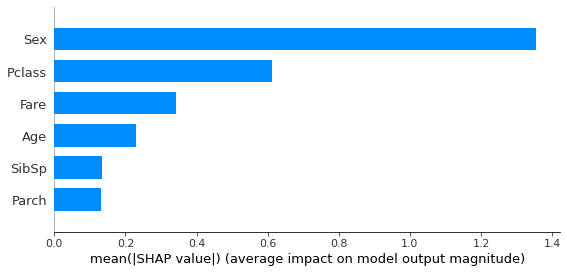

In [77]:
# shows average importance (contribution to the decision function from median one) of each feature
shap.summary_plot(shap_values, train, plot_type="bar")

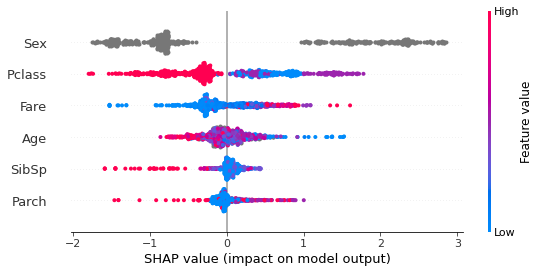

In [78]:
# shows feature contribution for each data point
shap.summary_plot(shap_values, train)

In [79]:
# can explain for a specific point
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train.iloc[0,:])

# task 4

Repeat task 1 for the CatBoostClassifier with shap as estimation of the feature importance.


In [111]:
clf4 = CatBoostClassifier(loss_function='Logloss',
                           verbose=False, 
                          cat_features=['Sex', 'Pclass'],
                          random_state=42)

clf4.fit(train, train_y)
score = clf4.score(test, test_y)
print(f'Initial score: {score}.')

Initial score: 0.8044692737430168.


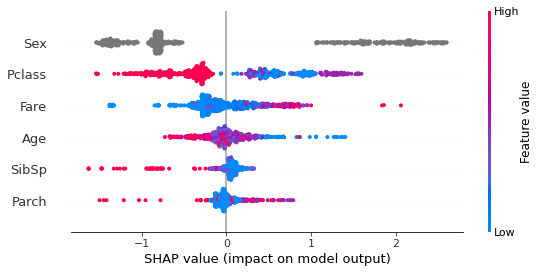

In [112]:
explainer4 = shap.TreeExplainer(clf4)
shap_values = explainer4.shap_values(train)
shap.summary_plot(shap_values, train)

In [113]:
mean_vals = np.abs(shap_values).mean(axis=0)

features = train.columns
ordering = np.argsort(mean_vals)[::-1]

print("Feature importance:")
for i in ordering:
  print(f'{i}. ({mean_vals[i]:.3f})\t{features[i]}')

Feature importance:
0. (1.302)	Sex
2. (0.610)	Pclass
3. (0.313)	Fare
1. (0.186)	Age
4. (0.126)	SibSp
5. (0.107)	Parch


In [144]:
n_features_left = 1
features_left = features[ordering[:n_features_left]]

shap_train = train[features_left]
shap_train_y = train_y
shap_test = test[features_left]
shap_test_y = test_y

print(f'Left features:', *features_left)

Left features: Sex


In [145]:
shap_clf = CatBoostClassifier(loss_function='Logloss',
                           verbose=False, 
                          cat_features=[x for x in ['Sex', 'Pclass'] if x in features_left],
                          random_state=42)

shap_clf.fit(shap_train, shap_train_y)
new_score = shap_clf.score(shap_test, shap_test_y)
print(f'Less features score: {new_score}.')
print(f'Threshold: {score * 0.9}')

Less features score: 0.7821229050279329.
Threshold: 0.7240223463687151


# task 5

On the reduced data from the previous task find best hyperparameters with a grid search.
For this


1.   initialize a CatBoostClassifier instance (with params that are not tuned)
2.   create a params dict with desired grid
3.   run grid_search method of the intitilized classifier 



In [155]:
shap_clf = CatBoostClassifier(loss_function='Logloss',
                           verbose=False, 
                          cat_features=[x for x in ['Sex', 'Pclass'] if x in features_left],
                          random_state=42)


In [156]:
params = {'iterations': range(300, 1001, 100), 
          'depth': range(1, 12,2), 
          'learning_rate': np.linspace(0.0001, 0.01, 5)}

In [157]:
res = shap_clf.grid_search(params, shap_train, shap_train_y)


bestTest = 0.6819496766
bestIteration = 299

0:	loss: 0.6819497	best: 0.6819497 (0)	total: 276ms	remaining: 1m 6s

bestTest = 0.55172922
bestIteration = 299

1:	loss: 0.5517292	best: 0.5517292 (1)	total: 491ms	remaining: 58.4s

bestTest = 0.5279289516
bestIteration = 299

2:	loss: 0.5279290	best: 0.5279290 (2)	total: 628ms	remaining: 49.6s

bestTest = 0.5240142711
bestIteration = 299

3:	loss: 0.5240143	best: 0.5240143 (3)	total: 762ms	remaining: 45s

bestTest = 0.5236588048
bestIteration = 286

4:	loss: 0.5236588	best: 0.5236588 (4)	total: 890ms	remaining: 41.8s

bestTest = 0.6783799282
bestIteration = 399

5:	loss: 0.6783799	best: 0.5236588 (4)	total: 1.08s	remaining: 42.2s

bestTest = 0.53869779
bestIteration = 399

6:	loss: 0.5386978	best: 0.5236588 (4)	total: 1.36s	remaining: 45.3s

bestTest = 0.5245662731
bestIteration = 399

7:	loss: 0.5245663	best: 0.5236588 (4)	total: 1.61s	remaining: 46.8s

bestTest = 0.5236587996
bestIteration = 381

8:	loss: 0.5236588	best: 0.5236588 (8)	t

In [158]:
res['params'] # best params

{'depth': 1, 'iterations': 400, 'learning_rate': 0.007525000000000001}

In [159]:
# train a model with best params and evaluate it on test
score5 = shap_clf.score(shap_test, shap_test_y)
print(f'Best score: {score5}')

Best score: 0.7821229050279329
